In [7]:
import os
import numpy as np
import pandas as pd
import requests
import time

os.chdir("C:/Users/johan_nii2lon/OneDrive/Desktop/Data Science Porject Management/Assigements/Assignment 5/Assignment05")

api_key = pd.read_csv("api_key.txt")
 

In [8]:
apiconde = requests.get("https://app.ticketmaster.com/discovery/v2/venues",
                          params = {"apikey":api_key , "countryCode": "DE"}).json()

venues = apiconde["_embedded"]["venues"]

entries = apiconde["page"]["size"]
page = apiconde["page"]["totalPages"]

name = [venue.get("name", "NA") for venue in venues]
city = [venue["city"].get("name", "NA")for venue in venues]
postalCode = [venue.get("postalCode", "NA")for venue in venues]
address = [venue.get("address", {}).get("line1", "NA") for venue in venues]
url = [venue.get("url", "NA") for venue in venues]
location = [venue.get("location", {}) for venue in venues]
longitude = [loc.get("longitude", "NA") for loc in location]
latitude = [loc.get("latitude", "NA")for loc in location]

df = pd.DataFrame({"name": name,
                   "city": city,
                   "postalCode": postalCode,
                   "address": address,
                    "url": url,
                    "longitude": longitude,
                    "latitude": latitude})

df["postalCode"] = pd.to_numeric(df["postalCode"], errors = "coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")

df.head()


,name,city,postalCode,address,url,longitude,latitude
0,Grosse Freiheit 36,Hamburg,22767.0,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767.0,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967.0,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.421380,52.486391
3,Virtual Event,Worldwide,NaN,NA,https://www.ticketmaster.de/venue/virtuelles-e...,10.000000,50.000000
4,Ev. St. Jacobi Kirche,Sangerhausen,6526.0,Marktplatz,http://www.ticketmaster.de/venue/290061,NaN,NaN


In [9]:
def df_country(country):
    api_content = requests.get(
        "https://app.ticketmaster.com/discovery/v2/venues/",
        params={
            "apikey": api_key,
            "countryCode": country
        }).json()
    time.sleep(0.2)
    page = api_content["page"]["totalPages"]
    entries = api_content["page"]["size"]

    df2 = pd.DataFrame()

    for i in range(page):
        api_content2 = requests.get(
        "https://app.ticketmaster.com/discovery/v2/venues/",
            params={
            "apikey": api_key,
            "countryCode": country,
            "page":i
            }).json()
        venues = api_content2.get("_embedded", {}).get("venues", [])
    
        name = [venue.get("name", "NA") for venue in venues]
        city = [venue.get("city", {}).get("name", "NA") for venue in venues]
        postalCode = [venue.get("postalCode", "NA") for venue in venues]
        address = [venue.get("address", {}).get("line1", "NA") for venue in venues]
        url = [venue.get("url", "NA") for venue in venues]
        location = [venue.get("location", {}) for venue in venues]
        longitude = [loc.get("longitude", "NA") for loc in location]
        latitude = [loc.get("latitude", "NA") for loc in location]

        df_page = pd.DataFrame({"name": name,
                           "city": city,
                           "postalCode": postalCode,
                           "address": address,
                           "url": url,
                           "longitude": longitude,
                           "latitude": latitude})
        df2 = pd.concat([df2, df_page], ignore_index=True)
        
    df2["postalCode"] = pd.to_numeric(df2["postalCode"], errors = "coerce")
    df2["longitude"] = pd.to_numeric(df2["longitude"], errors="coerce")
    df2["latitude"] = pd.to_numeric(df2["latitude"], errors="coerce")
    return(df2)

dfde = df_country("DE")

dfde.head()

,name,city,postalCode,address,url,longitude,latitude
0,Grosse Freiheit 36,Hamburg,22767.0,Grosse Freiheit 36,http://www.ticketmaster.de/venue/287636,9.957905,53.551187
1,Gruenspan,Hamburg,22767.0,Grosse Freiheit 58,http://www.ticketmaster.de/venue/287155,9.958075,53.551885
2,Huxleys Neue Welt,Berlin,10967.0,Hasenheide 107 – 113,http://www.ticketmaster.de/venue/286842,13.421380,52.486391
3,Virtual Event,Worldwide,NaN,NA,https://www.ticketmaster.de/venue/virtuelles-e...,10.000000,50.000000
4,Ev. St. Jacobi Kirche,Sangerhausen,6526.0,Marktplatz,http://www.ticketmaster.de/venue/290061,NaN,NaN


In [2]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


<AxesSubplot:>

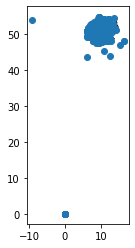

In [12]:
# import package
import geopandas as gpd

# create GeoDataFrame with special column for longitude / latitude
longitude_de = dfde["longitude"]
latitude_de = dfde["latitude"]
dfde_geo = gpd.GeoDataFrame(
    dfde, geometry = gpd.points_from_xy(longitude_de,latitude_de)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot for Germany
map = map[map.name == "Germany"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
dfde_geo.plot(ax = map)

<AxesSubplot:>

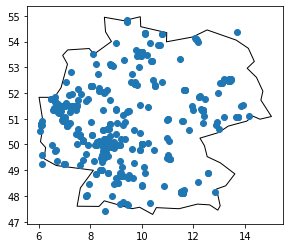

In [19]:
#set values beyond the borders to NA
dfde['longitude'] = np.where((5.866 <= dfde['longitude']) & (dfde['longitude'] <= 15.042), dfde['longitude'], np.nan)
dfde['latitude'] = np.where((47.270 <= dfde['latitude']) & (dfde['latitude'] <= 55.059), dfde['latitude'], np.nan)

# create GeoDataFrame with columns for latitude und longitude
longitude_de = dfde["longitude"]
latitude_de = dfde["latitude"]
dfde_geo = gpd.GeoDataFrame(
    dfde, geometry = gpd.points_from_xy(longitude_de,latitude_de)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot for Germany
map = map[map.name == "Germany"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
dfde_geo.plot(ax = map)

<AxesSubplot:>

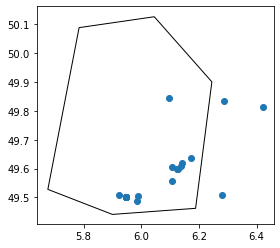

In [22]:
# do the same for luxembourg
dflu = df_country("LU")


#set values beyond the borders to NA
dflu['longitude'] = np.where((5.733333 <= dflu['longitude']) & (dflu['longitude'] <=6.533333), dflu['longitude'], np.nan)
dflu['latitude'] = np.where((49.447778 <= dflu['latitude']) & (dflu['latitude'] <= 50.182944), dflu['latitude'], np.nan)

# create GeoDataFrame with columns for latitude und longitude
longitude_lu = dflu["longitude"]
latitude_lu = dflu["latitude"]
dflu_geo = gpd.GeoDataFrame(
    dflu, geometry = gpd.points_from_xy(longitude_lu,latitude_lu)
)

# create visualization based on the given code
# get a base map of Germany
map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# create plot for Germany
map = map[map.name == "Luxembourg"].plot(color = "white", edgecolor = "black")
# plot the map with dots for the venues
dflu_geo.plot(ax = map)